In [61]:
from importlib.metadata import version

import torch

torch.manual_seed(123)
print("TORCH VERSION :", version("torch"))
device = (
    "cuda" if torch.cuda.is_available() else "mps" if torch.backend.mps.is_available() else "cpu"
)
print("GPU  : ", device)

TORCH VERSION : 2.2.1
GPU  :  cuda


In [62]:
import torch.nn as nn

In [63]:
# Layer Normalization

Layer normalization centers the activations of a neural network layer around a mean of 0 and normalizes their variance to 1

Let's validate the claim

In [64]:
x = torch.rand(2, 4)
layer = nn.Sequential(nn.Linear(4, 3), nn.ReLU())
output = layer(x)
print("output", output)
print(
    "**" * 20,
)
print("Before LayerNorm")
print(
    "**" * 20,
)
print("Mean", output.mean(dim=-1, keepdim=True))
print("Var", output.var(dim=-1, keepdim=True))
print(
    "**" * 20,
)
print("After LayerNorm")
torch.set_printoptions(sci_mode=False)
print(
    "**" * 20,
)

print(">> Call it manually")

ln_out = (output - output.mean(dim=-1, keepdim=True)) / torch.sqrt(
    output.var(dim=-1, keepdim=True)
)
print("Mean", ln_out.mean(dim=-1, keepdim=True))
print("Var", ln_out.var(dim=-1, keepdim=True))

print(">> Cal it nn.LayeNorm")
ln_out = nn.LayerNorm(3)(output)
print("Mean", ln_out.mean(dim=-1, keepdim=True))
print("Var", ln_out.var(dim=-1, keepdim=True))

output tensor([[0.4593, 0.0000, 0.2737],
        [0.5204, 0.0000, 0.3925]], grad_fn=<ReluBackward0>)
****************************************
Before LayerNorm
****************************************
Mean tensor([[0.2444],
        [0.3043]], grad_fn=<MeanBackward1>)
Var tensor([[0.0534],
        [0.0735]], grad_fn=<VarBackward0>)
****************************************
After LayerNorm
****************************************
>> Cal it manually
Mean tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Var tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)
>> Cal it nn.LayeNorm
Mean tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Var tensor([[1.4996],
        [1.4997]], grad_fn=<VarBackward0>)


In [65]:
## Here we see var for layer norm calculated using nn.LayerNorm is not equal to abs 1.0

In [66]:
## Use nn.LayerNorm
batch, seq_len, embedding_dim = 1, 5, 10
x = torch.rand(1, 5, 10)

ln = nn.LayerNorm(embedding_dim)
ln(x)

tensor([[[     1.1169,     -1.1728,      0.0684,     -1.1630,      0.7117,
               0.8475,     -1.9342,      0.9364,      0.3283,      0.2608],
         [     1.1683,      2.0452,      0.0321,     -1.4593,     -0.2916,
              -1.1637,      0.4462,     -0.0822,     -0.8129,      0.1180],
         [     1.7241,     -1.1016,     -0.7970,     -1.3138,     -0.4516,
               1.5688,      0.7992,      0.0929,     -0.2861,     -0.2352],
         [     0.7670,     -0.0220,     -1.2466,     -0.7707,      1.4821,
               0.2672,     -1.0640,      0.4171,      1.4403,     -1.2705],
         [    -0.9695,     -0.4962,      0.2585,     -0.2121,      0.0002,
              -1.4888,      0.9955,      1.7004,      1.2416,     -1.0296]]],
       grad_fn=<NativeLayerNormBackward0>)

In the std calculation, setting unbiased=False means using the formula to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses n-1 in the denominator), thus providing a biased estimate of the variance

In [89]:
class LayerNormalization(nn.Module):

    def __init__(self, eps: float = 10**-6, unbiased: bool = False) -> None:
        super().__init__()
        self.eps = eps
        self.unbiased = unbiased
        self.alpha = nn.Parameter(torch.ones(1))  # multiplicative parameter
        self.bias = nn.Parameter(torch.zeros(1))  # additive parameter

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True, unbiased=self.unbiased)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [90]:
x = torch.rand(1, 10, 12)
x = torch.exp(x)
LayerNormalization()(x).shape

torch.Size([1, 10, 12])

Layer normalization (LayerNorm) has been successfully applied to various deep neural networks to help stabilize training and boost model convergence because of its capability in handling re-centering and re-scaling of both inputs and weight matrix. However, the computational overhead introduced by LayerNorm makes these improvements expensive and significantly slows the underlying network,

re-centering invariance in LayerNorm is dispensable .RMSNorm regularizes the summed inputs to a neuron in one layer according to root mean square (RMS), giving the model re-scaling invariance property and implicit learning rate adaptation ability. RMSNorm is computationally simpler and thus more efficient than LayerNorm

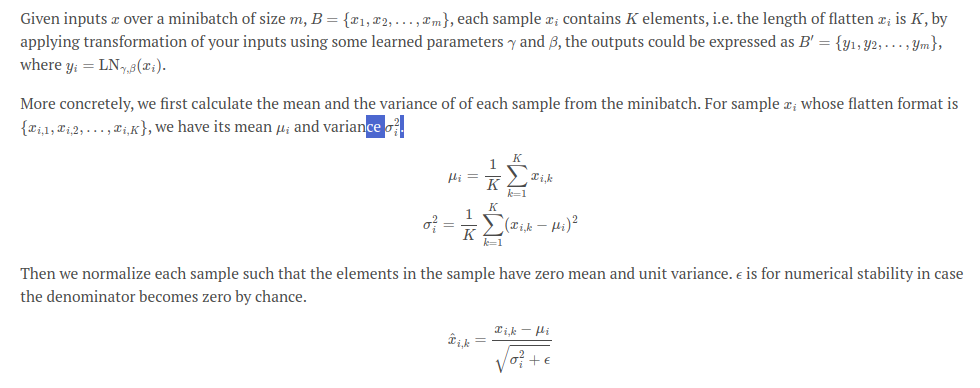

In [74]:
# RMS Layer Normalization

In [91]:
class RMSLayerNormalization(nn.Module):
    """https://arxiv.org/abs/1910.07467"""

    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.w = nn.Parameter(torch.ones(1))

    def forward(self, x):
        rvariance = torch.rsqrt((x.pow(2)).mean(dim=-1, keepdim=True) + self.eps)  # 1/variance
        norm = (x * rvariance).type_as(x)
        return self.w * norm

In [92]:
x = torch.rand(1, 10, 12)

RMSLayerNormalization()(x).shape

torch.Size([1, 10, 12])

In [93]:
x = torch.rand(1, 1024, 2048)
layer = nn.Sequential(nn.Linear(2048, 1500), nn.ReLU())
output = layer(x)
# print("output",output)
print(
    "**" * 20,
)
print("Before LayerNorm")
print(
    "**" * 20,
)
print("Mean", output.mean(dim=-1, keepdim=True).mean())
print("Var", output.var(dim=-1, keepdim=True).mean())
print(
    "**" * 20,
)
print("After LayerNorm")
torch.set_printoptions(sci_mode=False)
print(
    "**" * 20,
)

print(">> Class : LayerNormalization")

ln_out = LayerNormalization()(output)
print("Mean", ln_out.mean(dim=-1, keepdim=True).mean())
print("Var", ln_out.var(dim=-1, keepdim=True).mean())

print(">> Class : RMSLayerNormalization")
ln_out = RMSLayerNormalization()(output)
print("Mean", ln_out.mean(dim=-1, keepdim=True).mean())
print("Var", ln_out.var(dim=-1, keepdim=True).mean())

****************************************
Before LayerNorm
****************************************
Mean tensor(0.1235, grad_fn=<MeanBackward0>)
Var tensor(0.0346, grad_fn=<MeanBackward0>)
****************************************
After LayerNorm
****************************************
>> Class : LayerNormalization
Mean tensor(    0.0000, grad_fn=<MeanBackward0>)
Var tensor(1.0007, grad_fn=<MeanBackward0>)
>> Class : RMSLayerNormalization
Mean tensor(0.5532, grad_fn=<MeanBackward0>)
Var tensor(0.6944, grad_fn=<MeanBackward0>)
